In [1]:
import numpy as np
import pandas as pd
from scipy.io import loadmat

mat = loadmat('/content/mill.mat') # Load the .mat file
mill = mat['mill']
mill.shape

FileNotFoundError: [Errno 2] No such file or directory: '/content/mill.mat'

In [3]:
records = []
for i in range(mill.shape[1]):
    entry = mill[0, i]
    meta = [
        entry[0][0][0],  # case
        entry[1][0][0],  # run
        entry[2][0][0],  # VB
        entry[3][0][0],  # time
        entry[4][0][0],  # DOC
        entry[5][0][0],  # feed
        entry[6][0][0]   # material
    ]

    # Get all 6 signal channels (columns 7-12)
    signals = [entry[j].flatten() for j in range(7, 13)]

    # Find the maximum length among all signals
    max_length = max(len(s) for s in signals)

    # Pad shorter signals with NaN if needed
    signals_padded = []
    for s in signals:
        if len(s) < max_length:
            s = np.pad(s, (0, max_length - len(s)),
                       mode='constant', constant_values=np.nan)
        signals_padded.append(s)

    # Create records for each time point
    for t in range(max_length):
        signal_values = [s[t] for s in signals_padded]
        records.append(meta + signal_values)

# Create a DataFrame
columns = [
    'case', 'run', 'VB', 'time', 'DOC', 'feed', 'material', # copy the simple values of initial 7 column names
    'smcAC', 'smcDC', 'vib_table', 'vib_spindle', 'AE_table', 'AE_spindle' # flattendata to .csv file
]

df = pd.DataFrame(records, columns=columns)

# Write to CSV
df.to_csv('mill_data.csv', index=False)

In [4]:
data=pd.read_csv('/content/mill_data.csv')
data.shape

(1509360, 13)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1509360 entries, 0 to 1509359
Data columns (total 13 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   case         1509360 non-null  int64  
 1   run          1509360 non-null  int64  
 2   VB           1314000 non-null  float64
 3   time         1509360 non-null  int64  
 4   DOC          1509360 non-null  float64
 5   feed         1509360 non-null  float64
 6   material     1509360 non-null  int64  
 7   smcAC        1509360 non-null  float64
 8   smcDC        1509360 non-null  float64
 9   vib_table    1509360 non-null  float64
 10  vib_spindle  1509360 non-null  float64
 11  AE_table     1509360 non-null  float64
 12  AE_spindle   1509360 non-null  float64
dtypes: float64(9), int64(4)
memory usage: 149.7 MB


In [6]:
data.describe()

,case,run,VB,time,DOC,feed,material,smcAC,smcDC,vib_table,vib_spindle,AE_table,AE_spindle
count,1.509360e+06,1.509360e+06,1.314000e+06,1.509360e+06,1.509360e+06,1.509360e+06,1.509360e+06,1.509360e+06,1.509360e+06,1.509360e+06,1.509360e+06,1.509360e+06,1.509360e+06
mean,8.344808e+00,7.141676e+00,3.376027e-01,2.600795e+01,1.031742e+00,3.732907e-01,1.345842e+00,2.103678e+23,-5.632651e+14,6.311065e+23,2.770805e+28,-6.893067e+27,-2.802224e+23
std,4.746539e+00,4.960135e+00,2.596345e-01,2.323086e+01,3.632190e-01,1.249884e-01,4.756421e-01,1.126554e+27,3.817644e+17,1.049831e+27,4.157843e+31,3.053705e+31,1.317981e+25
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,7.500000e-01,2.500000e-01,1.000000e+00,-1.587606e+29,-3.696429e+19,-1.587617e+29,-1.044562e+34,-1.040523e+34,-6.201736e+26
25%,3.000000e+00,3.000000e+00,1.500000e-01,7.000000e+00,7.500000e-01,2.500000e-01,1.000000e+00,-1.401367e+00,4.125977e+00,5.541992e-01,2.722168e-01,1.367188e-01,1.641846e-01
50%,1.000000e+01,6.000000e+00,2.850000e-01,1.900000e+01,7.500000e-01,2.500000e-01,1.000000e+00,-1.464844e-01,6.044922e+00,8.276367e-01,2.893066e-01,1.770020e-01,2.154541e-01
75%,1.200000e+01,1.000000e+01,4.700000e-01,3.900000e+01,1.500000e+00,5.000000e-01,2.000000e+00,1.071777e+00,8.369141e+00,1.120605e+00,3.137207e-01,2.307129e-01,2.856445e-01
max,1.600000e+01,2.300000e+01,1.530000e+00,1.050000e+02,1.500000e+00,5.000000e-01,2.000000e+00,1.587607e+29,3.696438e+19,1.587619e+29,1.044565e+34,1.040523e+34,1.249390e+00


In [7]:
data['VB'].isna().sum()

np.int64(195360)

In [14]:
data = data.dropna(subset=['VB'], axis=0)

In [15]:
data.shape

(1314000, 13)

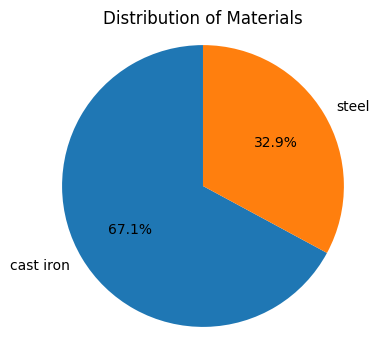

In [19]:
import matplotlib.pyplot as plt

# Count the occurrences of each material
material_counts = data['material'].value_counts()

# Map the numerical labels to material names
material_labels = {1: 'cast iron', 2: 'steel'}
labels = [material_labels[i] for i in material_counts.index]


# Create the pie chart
plt.figure(figsize=(4,4))
plt.pie(material_counts, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Materials')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [22]:
# Define your input features
columns = [
    'case', 'run','time', 'DOC', 'feed', 'material', # copy the simple values of initial 7 column names
    'smcAC', 'smcDC', 'vib_table', 'vib_spindle', 'AE_table', 'AE_spindle' # flattendata to .csv file
]
X = df[columns]
y = df['VB']  # Target: flank wear

In [26]:
# Create a dictionary of {case: last_run}
eol_dict = data.groupby('case')['run'].last().to_dict()

# Map EOL values to each row
data["EOL"] = data['case'].map(eol_dict)
data["EOL"]
data["EOL"].unique()
data.head()

,case,run,VB,time,DOC,feed,material,smcAC,smcDC,vib_table,vib_spindle,AE_table,AE_spindle,EOL
0,1,1,0.0,2,1.5,0.5,1,-0.017090,0.625000,0.078125,0.314941,0.087280,0.103760,17
1,1,1,0.0,2,1.5,0.5,1,0.263672,0.810547,0.085449,0.301514,0.098267,0.123291,17
2,1,1,0.0,2,1.5,0.5,1,0.207520,0.781250,0.078125,0.303955,0.092163,0.104980,17
3,1,1,0.0,2,1.5,0.5,1,0.302734,0.849609,0.073242,0.300293,0.095215,0.111084,17
4,1,1,0.0,2,1.5,0.5,1,0.239258,1.098633,0.083008,0.299072,0.083008,0.092163,17


# **Classification Problem Formulation**
The challange of this competetion was to predict the Remaining Useful Life by using the given sensor's data and operational conditions.

But in this project, we ll try to simplify that by converting it to a Classification Problem. Where, the classes/labels will of 3 types, i.e. Good Condition, Moderate Condition and Warning Condition.

Good Condition - 0

Moderate Condition - 1

Warning Condition - 2

labels corresponding to each conditions

Defining the labels
Here we will define the engine's condition with Life Ratio (LR), which is the ratio between Current Cycle and the End cycle/ End of Life(EOL). If LR=0, that means the component has just started its degradation and LR=1 means, it is completely degraded.

if LR <= 0.6 - Good Condition

if 0.6 < LR <= 0.8 - Moderate Condition

if 0.8 > LR - Warning Condition

In [29]:
# Calculate "LR"
data["LR"] = data['run'].div(data["EOL"])
data.head()

,case,run,VB,time,DOC,feed,material,smcAC,smcDC,vib_table,vib_spindle,AE_table,AE_spindle,EOL,LR,labels
0,1,1,0.0,2,1.5,0.5,1,-0.017090,0.625000,0.078125,0.314941,0.087280,0.103760,17,0.058824,0
1,1,1,0.0,2,1.5,0.5,1,0.263672,0.810547,0.085449,0.301514,0.098267,0.123291,17,0.058824,0
2,1,1,0.0,2,1.5,0.5,1,0.207520,0.781250,0.078125,0.303955,0.092163,0.104980,17,0.058824,0
3,1,1,0.0,2,1.5,0.5,1,0.302734,0.849609,0.073242,0.300293,0.095215,0.111084,17,0.058824,0
4,1,1,0.0,2,1.5,0.5,1,0.239258,1.098633,0.083008,0.299072,0.083008,0.092163,17,0.058824,0


In [28]:
import numpy as np

# Vectorized label assignment using np.select (best for multiple conditions)
conditions = [
    data["LR"] <= 0.6,
    data["LR"] <= 0.8,
]
choices = [0, 1]
data["labels"] = np.select(conditions, choices, default=2)

# Drop the 'LR' column in place
data.drop(columns=['LR'], inplace=False)
data.head()

,case,run,VB,time,DOC,feed,material,smcAC,smcDC,vib_table,vib_spindle,AE_table,AE_spindle,EOL,LR,labels
0,1,1,0.0,2,1.5,0.5,1,-0.017090,0.625000,0.078125,0.314941,0.087280,0.103760,17,0.058824,0
1,1,1,0.0,2,1.5,0.5,1,0.263672,0.810547,0.085449,0.301514,0.098267,0.123291,17,0.058824,0
2,1,1,0.0,2,1.5,0.5,1,0.207520,0.781250,0.078125,0.303955,0.092163,0.104980,17,0.058824,0
3,1,1,0.0,2,1.5,0.5,1,0.302734,0.849609,0.073242,0.300293,0.095215,0.111084,17,0.058824,0
4,1,1,0.0,2,1.5,0.5,1,0.239258,1.098633,0.083008,0.299072,0.083008,0.092163,17,0.058824,0


In [35]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
# Define your input features
columns = [
    'case', 'run','time', 'DOC', 'feed', 'material', # copy the simple values of initial 7 column names
    'smcAC', 'smcDC', 'vib_table', 'vib_spindle', 'AE_table', 'AE_spindle' # flattendata to .csv file
]
X = data[columns]
y = data['VB']  # Target: flank wear

In [34]:
y.count()

np.int64(1314000)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X[:1314000], y[:1314000], test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)

from sklearn.metrics import mean_squared_error, r2_score
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R² score:", r2_score(y_test, y_pred))